#  ResNet18 Uncertainty estimation using Hierarchical BN.

__Setup__: train net with vanilla BN, simultaniusly train variation approximation $r(\mu), r(\sigma)$, using exponential smoothed statistics. Dataset -- CIFAR5 (...), uncertainty estimation on the rest 5 classes.

__Architecture__: ResNet18 with pre-activation blocks
### Models

__BN__ -- net with vanilla batchnorm, stochasticity induced by choicing batch.

__HBN__ -- net trained with vanilla BN as well with updating parameters for approximation $r(\mu), r(\sigma)$.

__HBN-T__ -- the same as HBN plus tuning params of $r(\mu), r(\sigma)$ (by sampling from them on each layer in a decorrelated way) with fixed NN weights.

In [12]:
%env CUDA_VISIBLE_DEVICES=0
import torch
from StochBN import utils
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [13]:
bs_grid = [8, 16, 32, 128]

In [5]:
hbnt_res = {}

cifar5_train, cifar5_test = utils.get_dataloader(data='cifar5', test_bs=500)
cifar5rest_train, cifar5rest_test = utils.get_dataloader(data='cifar5-rest', test_bs=500)

for bs in bs_grid:
    hbn_net = utils.load_model('resnet-exps/cifar5/my-bn/bs{}/tuned_model'.format(bs))
    utils.set_bn_mode(hbn_net, 'StochBN')
    hbn_net.eval()
    hbnt_res[bs] = utils.uncertainty_acc(hbn_net, known=cifar5_test, unknown=cifar5rest_test)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [14]:
#torch.save(hbn_res, 'StochBN/results/cifar5/uncertainty/resnet18/hbn-tuned_res')

hbnt_res = torch.load('StochBN/results/cifar5/uncertainty/resnet18/hbn-tuned_res')

In [10]:
bn_res = {}
for bs in bs_grid:
    bn_net = utils.load_model('resnet-exps/cifar5/my-bn/bs{}/model'.format(bs))
    utils.set_bn_mode(bn_net, 'StochBN')
    bn_net.eval()
    bn_res[bs] = utils.uncertainty_acc(bn_net, cifar5_test, cifar5rest_test, bs=bs, bn_type='BN',
                                       vanilla_known=(cifar5_test.dataset.test_data, cifar5_test.dataset.test_labels),
                                       vanilla_unknown=(cifar5rest_test.dataset.test_data, cifar5rest_test.dataset.test_labels))

In [15]:
#torch.save(bn_res, 'StochBN/results/cifar5/uncertainty/resnet18/bn_res')


bn_res = torch.load('StochBN/results/cifar5/uncertainty/resnet18/bn_res')

In [16]:
hbn_res = {}

cifar5_train, cifar5_test = utils.get_dataloader(data='cifar5', test_bs=500)
cifar5rest_train, cifar5rest_test = utils.get_dataloader(data='cifar5-rest', test_bs=500)

for bs in bs_grid:
    hbn_net = utils.load_model('resnet-exps/cifar5/my-bn/bs{}/model'.format(bs))
    utils.set_bn_mode(hbn_net, 'StochBN')
    hbn_net.eval()
    hbn_res[bs] = utils.uncertainty_acc(hbn_net, known=cifar5_test, unknown=cifar5rest_test)
torch.save(hbn_res, 'StochBN/results/cifar5/uncertainty/resnet18/hbn_res')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [18]:
for bs in bs_grid[:]:
    print('\nbatch size {}'.format(bs))
    print('  EVAL   -- BN {:.3f}, HBN {:.3f}, HBN-T {:.3f}'.format(bn_res[bs][1]['eval/acc'],
                                                                   hbn_res[bs][1]['eval/acc'],
                                                                   hbnt_res[bs][1]['eval/acc']))

    print('ENSEMBLE -- BN {:.3f}, HBN {:.3f}, HBN-T {:.3f}'.format(bn_res[bs][1]['ensemble/acc'],
                                                                   hbn_res[bs][1]['ensemble/acc'],
                                                                   hbnt_res[bs][1]['ensemble/acc']))
    
    print('ONE SHOT -- BN {:.3f}, HBN {:.3f}, HBN-T {:.3f}'.format(bn_res[bs][1]['one_shot/acc'],
                                                                   hbn_res[bs][1]['one_shot/acc'],
                                                                   hbnt_res[bs][1]['one_shot/acc']))


batch size 8
  EVAL   -- BN 0.960, HBN 0.960, HBN-T 0.955
ENSEMBLE -- BN 0.960, HBN 0.959, HBN-T 0.940
ONE SHOT -- BN 0.956, HBN 0.954, HBN-T 0.861

batch size 16
  EVAL   -- BN 0.960, HBN 0.960, HBN-T 0.958
ENSEMBLE -- BN 0.961, HBN 0.959, HBN-T 0.924
ONE SHOT -- BN 0.958, HBN 0.959, HBN-T 0.819

batch size 32
  EVAL   -- BN 0.958, HBN 0.958, HBN-T 0.958
ENSEMBLE -- BN 0.958, HBN 0.958, HBN-T 0.957
ONE SHOT -- BN 0.957, HBN 0.957, HBN-T 0.949

batch size 128
  EVAL   -- BN 0.953, HBN 0.953, HBN-T 0.952
ENSEMBLE -- BN 0.955, HBN 0.953, HBN-T 0.952
ONE SHOT -- BN 0.954, HBN 0.953, HBN-T 0.943


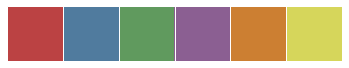

In [19]:
colors = sns.color_palette('Set1', desat=.6)
sns.palplot(colors)

## Uncertainty

### HBN-T

In [42]:
# net = utils.load_model('resnet-exps/cifar5/my-bn/bs32/tuned_tuned_model-0')
# utils.set_bn_mode(net, 'StochBN')
# net.eval()
# hbn32_40_res = utils.uncertainty_acc(net, known=cifar5_test, unknown=cifar5rest_test)

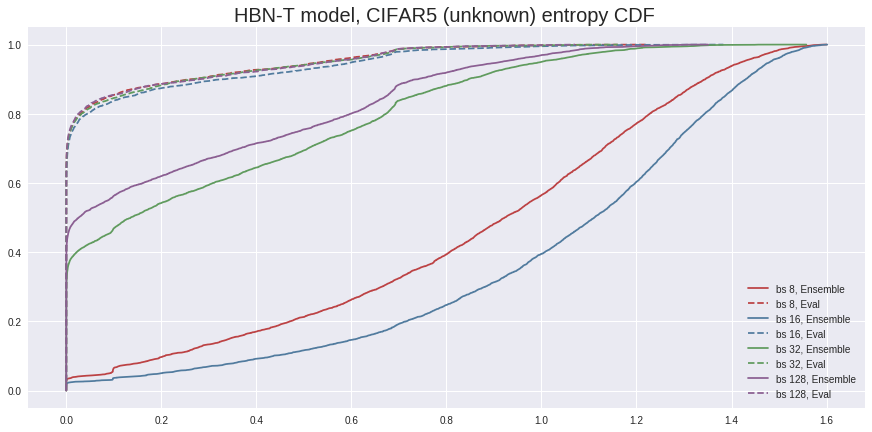

In [21]:
plt.figure(figsize=(15, 7))
plt.title('HBN-T model, CIFAR5 (unknown) entropy CDF ', size=20)
for bs, c in zip(bs_grid, colors):
    ent = hbnt_res[bs][0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='-', c=c, label='bs {}, Ensemble'.format(bs))

    ent = hbnt_res[bs][0]['eval/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='--', c=c, label='bs {}, Eval'.format(bs))

# ent = hbn32_40_res[0]['ensemble/entropy']
# n = len(ent)
# plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='-', c=colors[-1], label='bs {}, Ensemble'.format(bs))

# ent = hbn32_40_res[0]['eval/entropy']
# n = len(ent)
# plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='--', c=colors[-1], label='bs {}, Eval'.format(bs))
    

plt.legend()

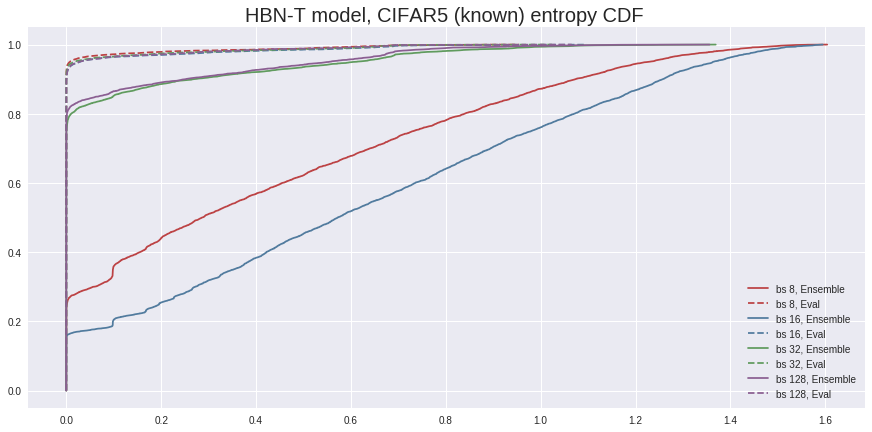

In [11]:
plt.figure(figsize=(15, 7))
plt.title('HBN-T model, CIFAR5 (known) entropy CDF ', size=20)
for bs, c in zip(bs_grid, colors):
    ent = hbn_res[bs][1]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='-', c=c, label='bs {}, Ensemble'.format(bs))

    ent = hbn_res[bs][1]['eval/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='--', c=c, label='bs {}, Eval'.format(bs))

plt.legend()

### HBN

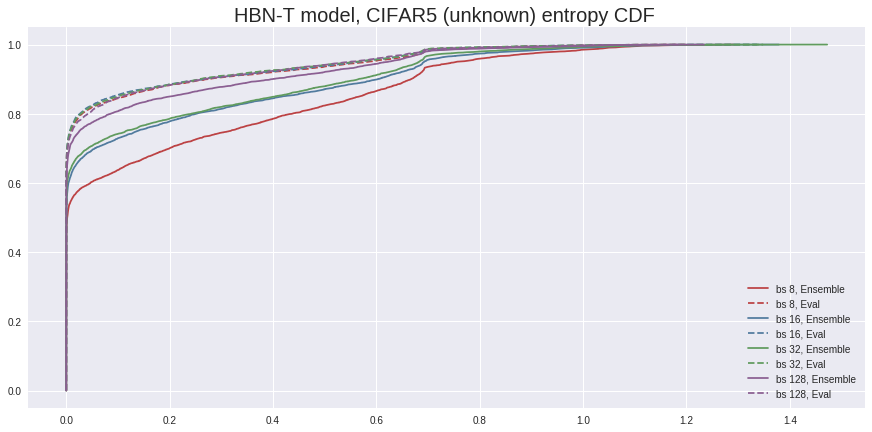

In [23]:
plt.figure(figsize=(15, 7))
plt.title('HBN-T model, CIFAR5 (unknown) entropy CDF ', size=20)
for bs, c in zip(bs_grid, colors):
    ent = hbn_res[bs][0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='-', c=c, label='bs {}, Ensemble'.format(bs))

    ent = hbn_res[bs][0]['eval/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='--', c=c, label='bs {}, Eval'.format(bs))

plt.legend()

### BN

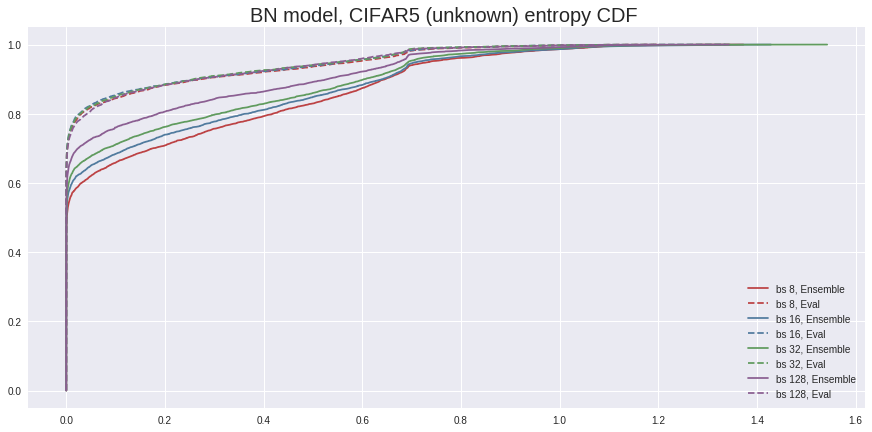

In [10]:
plt.figure(figsize=(15, 7))
plt.title('BN model, CIFAR5 (unknown) entropy CDF ', size=20)
for bs, c in zip(bs_grid, colors):
    ent = bn_res[bs][0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='-', c=c, label='bs {}, Ensemble'.format(bs))

    ent = bn_res[bs][0]['eval/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls='--', c=c, label='bs {}, Eval'.format(bs))

plt.legend()

### Ensembles

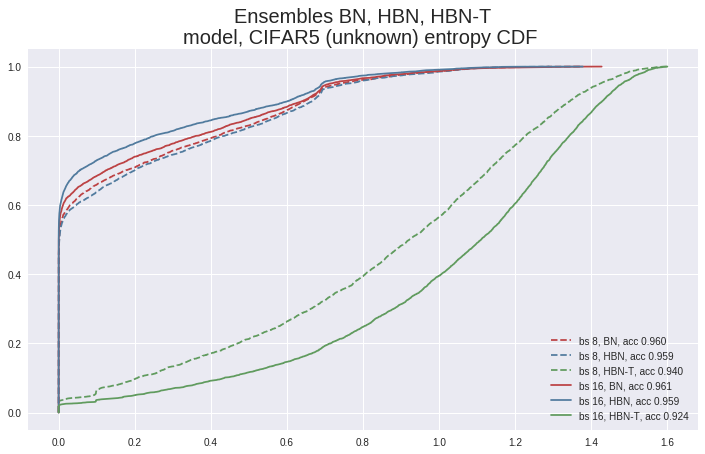

In [26]:
plt.figure(figsize=(12, 7))
plt.title('Ensembles BN, HBN, HBN-T\nmodel, CIFAR5 (unknown) entropy CDF ', size=20)
for bs, ls in zip(sorted(bn_res.keys())[:2], ['--', '-']):
    res = bn_res[bs]
    ent = res[0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls=ls, c=colors[0], label='bs {}, BN, acc {:.3f}'.format(bs, res[1]['ensemble/acc']))

    res = hbn_res[bs]
    ent = res[0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls=ls, c=colors[1], label='bs {}, HBN, acc {:.3f}'.format(bs, res[1]['ensemble/acc']))

    res = hbnt_res[bs]
    ent = res[0]['ensemble/entropy']
    n = len(ent)
    plt.plot(sorted(ent), (np.arange(n) + 1.) / n, ls=ls, c=colors[2], label='bs {}, HBN-T, acc {:.3f}'.format(bs, res[1]['ensemble/acc']))

plt.legend()